# SETUP

In [2]:
#link to the google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
 #Check the package pyreadr.
 !pip install pyreadr

In [3]:
import pandas as pd 
import pyreadr as py 
import numpy as np 
import tensorflow as tf
import gc 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib as plt
from google.colab import files
import seaborn as sns
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


gc.collect() 

pd.options.mode.chained_assignment = None

In [4]:
#TPU

import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU address is grpc://10.72.147.90:8470
Running on TPU  grpc://10.72.147.90:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.147.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.147.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER

In [5]:
BASE_SEQ_LEN = 500
NUM_VAR = 52
INPUT_SEQ_LEN = 32 
OUTPUT_SEQ_LEN = 1 
BATCH_SIZE = 128

# READ DATA

In [6]:
a1 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Training.RData")
fault_free_training = a1['fault_free_training']
a1 = None 
a2 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Training.RData")
faulty_training = a2['faulty_training']
a2 = None
a3 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Testing.RData")
fault_free_testing = a3['fault_free_testing']
a3 = None 
a4 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Testing.RData")
faulty_testing = a4['faulty_testing']
a4 = None 

In [7]:
gc.collect()

50

In [8]:
for col in fault_free_training.columns: 
    fault_free_training.loc[: , col] = fault_free_training.loc[: , col].astype('float32')

for col in faulty_training.columns: 
    faulty_training.loc[: , col] = faulty_training.loc[: , col].astype('float32')

for col in fault_free_testing.columns: 
    fault_free_testing.loc[: , col] = fault_free_testing.loc[: , col].astype('float32')

for col in faulty_testing.columns: 
    faulty_testing.loc[: , col] = faulty_testing.loc[: , col].astype('float32')


In [9]:
gc.collect()

50

In [37]:
def df_to_np_array(df = fault_free_training): 
    """ This function will turn the dataframe to numpy array, only use for faulty free dataset
    Parameter: dataframe
    Return: Numpy array
    """
    examples = []
    for i in df.simulationRun.unique():
        examples.append(df[df.simulationRun == i].iloc[:, 3:].values)
    
    return np.stack(examples)


def get_slice_random_segment(length):
    """This function will acquire a length of slice from the dataset.
    Parameter: length, length of the dataset
    return: array
    """
    def slice_random_segment(x):
      """This function will return the specific array
      Parameter: x, dataset
      return: array
      """
      #minval = min numbers of data points, maxval = max numbers of data points
      start = tf.random.uniform(shape=[], minval=0, maxval= BASE_SEQ_LEN-length, dtype=tf.int64)
      x = x[start:start+length]
      print(x)
      #reshape will turn x into the shape of (length, NUM_VAR)
      x = tf.reshape(x, (length, NUM_VAR))
      print(x)
      return x 
    return slice_random_segment

def get_split_xy(y_length):
  """This will get two specific group of data points.
  Parameter: y_length
  return: x, y 
  """
  def split_xy(x):
    """
    Parameter: dataset
    """
    y = x[-y_length:]
    return x[:-y_length], y 
  return split_xy

def get_dataset(train_data, shuffle = False, repeat = False): 
    train_data = df_to_np_array(train_data)
    ds = tf.data.Dataset.from_tensor_slices(train_data)
    ds = ds.map(get_slice_random_segment(length = INPUT_SEQ_LEN + OUTPUT_SEQ_LEN))
    ds = ds.map(get_split_xy(y_length=OUTPUT_SEQ_LEN))

    #Changing the value of buffer_size affects how uniform the shuffling
    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds.repeat(2)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    return ds 

  
def get_detection_xy(df , fault_number, simrun, scaler):
    """get the testing dataset
    Parameter: dataset, fault_number(only for testing dataset), number of simulation run, the scaler you use in the training process
    return: x:slice of dataset(testing), y:target value
    """
    
    scaled = scaler.transform(df[(df.faultNumber == fault_number) & (df.simulationRun == simrun)].iloc[:500, 3:])

    x = []
    y = []

    for i in range(BASE_SEQ_LEN - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN):
        x.append(scaled[i:i+ INPUT_SEQ_LEN])
        y.append(scaled[i+INPUT_SEQ_LEN: i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])

    x = np.stack(x)
    y = np.stack(y)

    return x,y 
    
    
def get_mse(model, df, scaler, fault_number, simrun):
    """ Get loss value: the mean squared error value
    Parameter: dataset, simulation run, model
    Return: loss value
    """
    x, y = get_detection_xy(df, fault_number, simrun, scaler) 
    y_pred_1 = model.predict(x, verbose = True)
    mse_1 = tfk.losses.MSE(y, y_pred_1).numpy()
    return mse_1.flatten()


In [28]:
def train_model(df, model):
  """This function is to tain the model
  Parameter: df, model
  Return: trained model, and trained scaler
  """
  # train_df = fault_free_training
  train_df = df[:]


  scaler = preprocessing.MinMaxScaler()
  scaler.fit(train_df.iloc[:, 3:].values)

  train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:].values)
  train_ds = get_dataset(train_df, shuffle = True, repeat=True)

  model.fit(
      train_ds, 
      epochs = 20,
      steps_per_epoch = 1000,
  )

  return model, scaler

In [64]:
def get_result( model, baseline, scaler, fault_number, simrun):
  """This function is to get and plot the result
  Paramter: baseline, simrun, trained model, and trained scaler
  """

  mse_model_1 = get_mse(model, fault_free_testing, scaler, 0, simrun)
  # print(len(mse_model_1))
  # print(type(mse_model_1))
  # print(mse_model_1)
  mse_model_2 = get_mse(model, faulty_testing, scaler, fault_number, simrun)
  # print(len(mse_model_2))
  # print(type(mse_model_2))
  # print(mse_model_2)
  # pd.DataFrame({'normal' : mse_model_1, 'with_fault' : mse_model_2, 'baseline': baseline}).plot(ylim = (0.0, 1.0))
  return mse_model_1, mse_model_2

In [41]:
faulty_testing.tail()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
9599995,20.0,500.0,956.0,0.26494,3719.600098,4536.700195,9.2265,26.875000,42.401001,2708.300049,75.407997,120.400002,0.31196,79.697998,48.987999,2630.800049,24.632000,49.551998,3108.399902,24.014999,64.709000,213.369995,338.089996,94.592003,76.837997,32.090000,8.8622,26.504000,6.7403,18.968,1.6853,32.252998,13.906,24.740999,1.2128,18.209000,2.2578,4.8537,2.3312,0.005927,0.86515,0.12132,54.085999,44.150002,63.375000,54.382000,26.018000,62.068001,20.708000,37.589001,35.120998,45.495998,42.653000,40.816002,15.846000
9599996,20.0,500.0,957.0,0.25252,3724.000000,4494.299805,9.1873,27.221001,41.999001,2706.000000,74.879997,120.430000,0.33990,79.739998,50.098999,2627.800049,26.879000,48.775002,3106.500000,22.903000,64.724998,214.330002,337.549988,94.585999,76.917999,31.728001,8.8455,26.573999,6.9132,18.830,1.6628,32.700001,13.793,24.455999,1.2055,18.410000,2.2281,4.7304,2.2030,0.005927,0.86515,0.12132,54.085999,44.150002,63.215000,54.236000,25.098000,61.556999,20.655001,40.933998,38.390999,43.699001,42.832001,41.853001,18.486000
9599997,20.0,500.0,958.0,0.25164,3700.800049,4537.299805,9.2514,26.659000,42.180000,2704.699951,75.070000,120.410004,0.34186,79.847000,49.272999,2626.699951,24.153999,49.615002,3104.100098,23.047001,64.787003,213.699997,337.200012,94.522003,77.127998,31.728001,8.8455,26.573999,6.9132,18.830,1.6628,32.700001,13.793,24.455999,1.2055,18.410000,2.2281,4.7304,2.2030,0.005927,0.86515,0.12132,54.085999,44.150002,63.615002,53.722000,25.184999,61.168999,20.650000,40.694000,35.960999,45.643002,43.146999,40.537998,18.127001
9599998,20.0,500.0,959.0,0.29097,3641.800049,4525.200195,9.3053,26.823000,42.234001,2705.000000,75.726997,120.410004,0.32497,80.008003,50.580002,2624.800049,24.288000,49.764000,3105.699951,23.391001,64.875000,214.649994,336.459991,94.768997,77.070000,32.044998,9.0099,26.555000,6.9274,19.361,1.5909,32.284000,13.822,24.462999,1.1300,18.712999,2.2772,4.8032,2.3770,0.005927,0.86515,0.12132,54.085999,44.150002,63.167000,54.185001,28.771000,61.139999,20.323000,39.773998,39.806999,45.988998,43.318001,40.826000,17.305000
9599999,20.0,500.0,960.0,0.29359,3622.199951,4485.100098,9.3070,26.922001,42.610001,2704.800049,75.406998,120.400002,0.32749,80.047997,50.735001,2624.300049,23.738001,48.437000,3105.500000,21.927999,64.962997,214.789993,335.970001,94.531998,76.924004,32.044998,9.0099,26.555000,6.9274,19.361,1.5909,32.284000,13.822,24.462999,1.1300,18.712999,2.2772,4.8032,2.3770,0.005927,0.86515,0.12132,54.085999,44.150002,63.502998,54.665001,28.513000,59.398998,20.145000,39.466999,40.264000,42.916000,43.556999,40.845001,20.782000


# CNN MODEL

In [13]:
#CNN
def get_model_CNN_1():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(128, 15, 9,activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

In [14]:
#CNN
def get_model_CNN_2():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(128, 5, 2, activation= 'relu'),
                              tfkl.Conv1D(128, 5, 2, activation= 'relu'),
                              tfkl.Conv1D(128, 4, 1, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

In [15]:
#CNN
def get_model_CNN_3():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(64, 5, 1, activation= 'relu'),
                              tfkl.Conv1D(64, 5, 1, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Conv1D(128, 7, 3, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

In [16]:
#CNN
def get_model_CNN_4():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(64, 5, 1,activation= 'relu'),
                              tfkl.Conv1D(64, 5, 1, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Conv1D(128, 5, 2, activation= 'relu'),
                              tfkl.Conv1D(128, 3, 2, activation= 'relu'),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

# Train the model

In [17]:
cnn_model_1 = get_model_CNN_1()
cnn_model_1, scaler = train_model(fault_free_training ,cnn_model_1)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


1000/1000 [==============================] - 11s 9ms/step - loss: 0.0119
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0107
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0105
Epoch 4/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0104
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0104
Epoch 6/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0103
Epoch 7/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0103
Epoch 8/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0103
Epoch 9/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0102
Epoch 10/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0102
Epoch 11/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0102
Epoch 12/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0102
E

In [ ]:
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 128)            99968     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 52)             6708      
Total params: 106,676
Trainable params: 106,676
Non-trainable params: 0
_________________________________________________________________


In [49]:
cnn_model_2 = get_model_CNN_2()
cnn_model_2, scaler = train_model(fault_free_training ,cnn_model_2)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 13s 10ms/step - loss: 0.0109
Epoch 2/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0102
Epoch 3/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0101
Epoch 4/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0100
Epoch 5/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0100
Epoch 6/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0099
Epoch 7/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0099
Epoch 8/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0099
Epoch 9/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0099
Epoch 10/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0099
Epoch 11/20
1000/1000 [================

In [ ]:
cnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 128)           33408     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 128)            65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 52)             6708      
Total params: 187,828
Trainable params: 187,828
Non-trainable params: 0
_________________________________________________________________


In [50]:
cnn_model_3 = get_model_CNN_3()
cnn_model_3, scaler = train_model(fault_free_training ,cnn_model_3)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 12s 10ms/step - loss: 0.0111
Epoch 2/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0103
Epoch 3/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0102
Epoch 4/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0101
Epoch 5/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0101
Epoch 6/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0101
Epoch 7/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0100
Epoch 8/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0100
Epoch 9/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0100
Epoch 10/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0100
Epoch 11/20
1000/1000 [================

In [ ]:
cnn_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 28, 64)            16704     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 64)            20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 128)            57472     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 52)             6708      
Total params: 101,428
Trainable params: 101,428
Non-trainable params: 0
________________________________________________

In [51]:
cnn_model_4 = get_model_CNN_4()
cnn_model_4, scaler = train_model(fault_free_training ,cnn_model_4)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 13s 10ms/step - loss: 0.0111
Epoch 2/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0104
Epoch 3/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0102
Epoch 4/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0102
Epoch 5/20
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0101
Epoch 6/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0101
Epoch 7/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0101
Epoch 8/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0100
Epoch 9/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0100
Epoch 10/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0100
Epoch 11/20
1000/1000 [================

In [ ]:
cnn_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 28, 64)            16704     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 64)            20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 4, 128)            41088     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 52)             6708      
Total params: 134,324
Trainable params: 134,324
Non-trainable params: 0
________________________________________________

# RNN Model

In [ ]:
#LSTM
def get_model_1():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.LSTM(64, return_sequences=True), 
                              tfkl.LSTM(64, return_sequences=False),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = tfk.losses.MeanSquaredError() )

      return model 

In [ ]:
#LSTM
def get_model_2():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.LSTM(64, return_sequences=True), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.LSTM(64, return_sequences=False),
                              tfkl.Dropout(0.5),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

In [ ]:
#GRU
def get_model_3():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.GRU(64, return_sequences=True), 
                              tfkl.GRU(64, return_sequences=False),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.GRU(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

In [ ]:
#GRU
def get_model_4():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              # tfkl.Conv1D(64, 5, 1),
                              tfkl.GRU(64, return_sequences=True), 
                              tfkl.GRU(64, return_sequences=True),
                              tfkl.GRU(64, return_sequences=False),
                              tfkl.Dropout(0.5),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.GRU(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

# Get the result

fault_number:1
15/15 [==============================] - 1s 9ms/step
fault_number:2
15/15 [==============================] - 1s 9ms/step
fault_number:3
15/15 [==============================] - 1s 8ms/step
fault_number:4
15/15 [==============================] - 1s 9ms/step
fault_number:5
15/15 [==============================] - 1s 8ms/step
fault_number:6
15/15 [==============================] - 1s 8ms/step
fault_number:7
15/15 [==============================] - 1s 9ms/step
fault_number:8
15/15 [==============================] - 1s 9ms/step
fault_number:9
15/15 [==============================] - 1s 8ms/step
fault_number:10
15/15 [==============================] - 1s 9ms/step
fault_number:11
15/15 [==============================] - 1s 8ms/step
fault_number:12
15/15 [==============================] - 1s 9ms/step
fault_number:13
15/15 [==============================] - 1s 9ms/step
fault_number:14
15/15 [==============================] - 1s 8ms/step
fault_number:15
15/15 [====================

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f209988d3d0>,
      dtype=object)

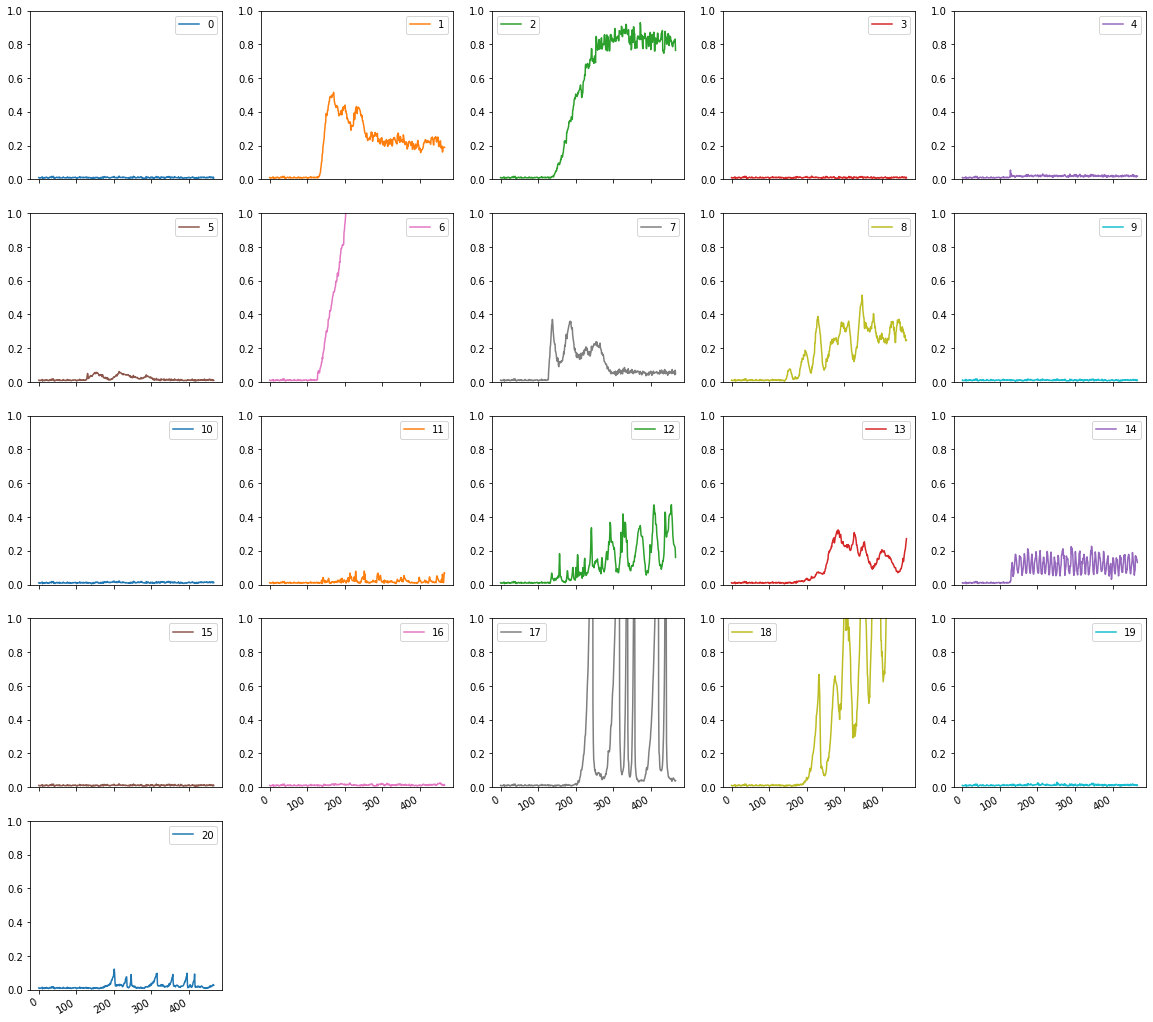

In [84]:
##the fault data in testing data starting from 8 hr(index 160)
baseline = 0.1
run = 1
fault_number = [i for i in range(1,21)]
# models = [cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4]
models = [cnn_model_1]
temp_dict = {}

for i in range(len(models)):
  for j in fault_number:
    print("fault_number:" + str(j))
    fault_free, faulty = get_result(models[i], 0.1, scaler, j, run)
    temp_dict[0] = fault_free
    temp_dict[j] = faulty
df_loss = pd.DataFrame(temp_dict)
df_loss.plot(subplots = True, figsize = (20,20), ylim = (0.0, 1.0), layout= (5,5))

In [ ]:
run = 1
mse_f = []
mse_fault_f = []
target = "get_model_CNN_" + str(4) + "()"
for j in range(30):
  cnn_model = eval(target)
  print(cnn_model)
  cnn_model, scaler = train_model(fault_free_training ,cnn_model)
  mse_model_1 = get_mse(cnn_model, fault_free_testing, scaler, run)
  mse_model_2 = get_mse(cnn_model, faulty_testing, scaler, run)
  mse_fault_f.append(mse_model_1)
  mse_f.append(mse_model_2)
  
np.savetxt('myfile.csv', mse_fault_f, delimiter=',', header = "4_fault_free")
np.savetxt('myfile_f.csv', mse_f, delimiter=',', header = "4_fault")

files.download('myfile.csv')
files.download('myfile_f.csv')


# Cross Validation

In [ ]:
#cross validation
for train_split, val_split in KFold().split([i+1 for i in range(500)]):
    train_df = fault_free_training[fault_free_training.simulationRun.isin(train_split)]
    val_df = fault_free_training[fault_free_training.simulationRun.isin(val_split)]

  
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(train_df.iloc[:, 3:].values)

    train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:].values)
    val_df.iloc[:, 3:] = scaler.transform(val_df.iloc[:, 3:].values)

    train_ds = get_dataset(train_df, shuffle = True, repeat=True)
    val_ds = get_dataset(val_df)


    model = get_model_1() 


    model.fit(
        train_ds, 
        epochs = 20,
        steps_per_epoch = 1000,
        validation_data= val_ds,
        
    )

    break


Epoch 1/20
1000/1000 [==============================] - 18s 11ms/step - loss: 0.1253 - val_loss: 0.1170
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0784 - val_loss: 0.0672
Epoch 3/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0535 - val_loss: 0.0463
Epoch 4/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0472 - val_loss: 0.0478
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0470 - val_loss: 0.0474
Epoch 6/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0468 - val_loss: 0.0471
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0466 - val_loss: 0.0473
Epoch 8/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0460 - val_loss: 0.0422
Epoch 9/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0412 - val_loss: 0.0385
Epoch 10/20
1000/1000 [==============================] - 10s 10ms/step -

In [ ]:
#add the ndarray then do the significant test from data point 160